In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import (ExponentialSmoothing, 
                                         SimpleExpSmoothing,Holt)
import seaborn as sns

F:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
F:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
data = pd.read_excel('E:/postgraduate/案例选题数据及说明/布伦特原油.xlsx')

In [3]:
data['时间'] = data['时间'].str.split(',').str[0]
data.index = data['时间']
data = data[['开盘','最高','最低','收盘','总手']]
data.head()

,开盘,最高,最低,收盘,总手
时间,,,,,
2021-01-04,51.50,53.33,50.56,50.67,382895
2021-01-05,50.95,53.90,50.70,53.57,455351
2021-01-06,53.52,54.73,53.02,54.15,414408
2021-01-07,54.13,54.90,53.94,54.52,267188
2021-01-08,54.56,56.36,54.34,56.36,336650


In [4]:
data1 = data.loc['2021-01-12':'2022-02-23']#取2022-2-24之前的数据
data1.tail()

,开盘,最高,最低,收盘,总手
时间,,,,,
2022-02-17,92.20,94.50,92.14,92.94,347788
2022-02-18,92.73,94.15,90.12,93.61,348345
2022-02-21,94.29,97.40,92.57,97.35,217035
2022-02-22,96.55,99.50,95.80,96.50,316384
2022-02-23,96.65,98.71,95.81,97.54,238632


Text(0, 0.5, '收盘价')

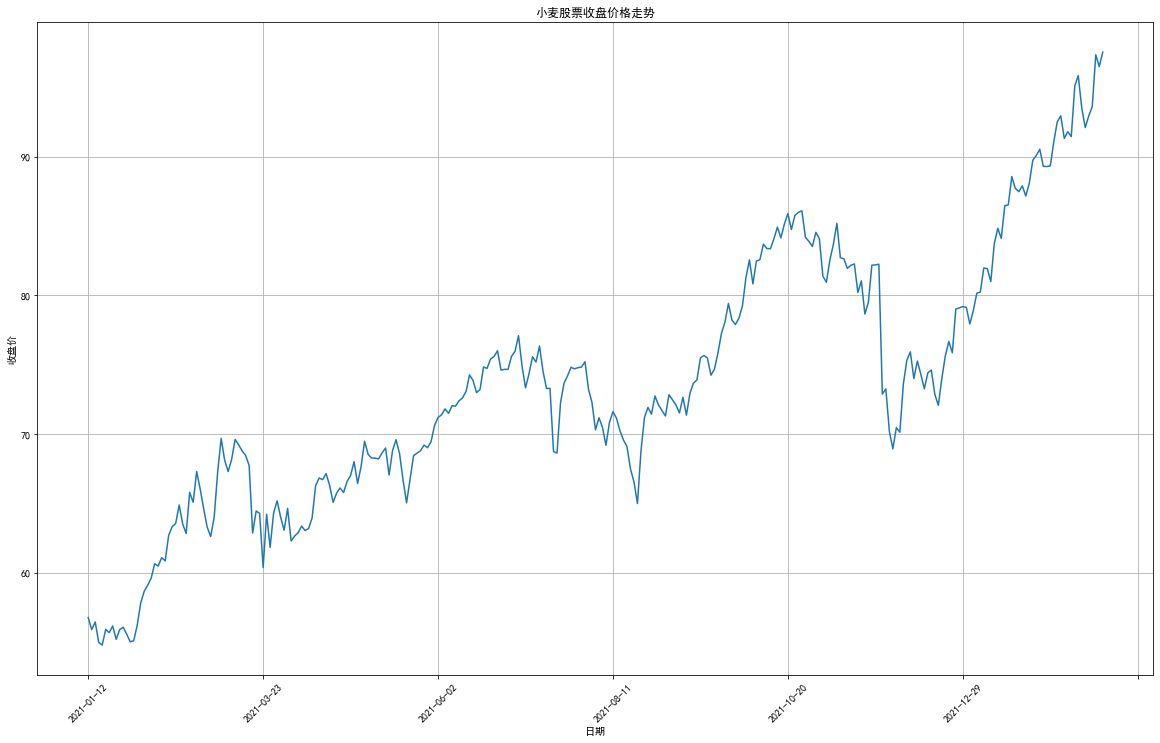

In [5]:
#绘制时序图
ts = data1['收盘']
plt.rcParams['font.sans-serif'] = ['simhei']  #用来正常显示中文标签 
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号 
ts.plot(figsize=(20,12))         
plt.title("小麦股票收盘价格走势")  #添加图标题 
plt.xticks(rotation=45)  #横坐标旋转45度
plt.grid()
plt.xlabel('日期')   #添加图的标签（x轴，y轴）
plt.ylabel('收盘价')

<ipython-input-6-ddfa3ec3e235>:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead.
  decomposition = seasonal_decompose(ts,model='multiplicative', freq=30)


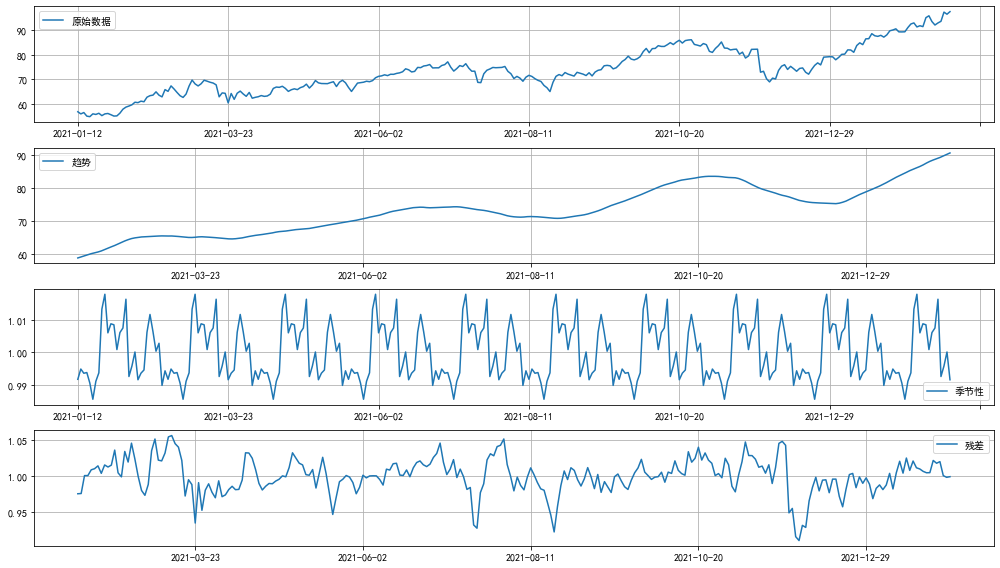

In [6]:
import matplotlib.ticker as ticker
rcParams['figure.figsize'] = 14, 8
decomposition = seasonal_decompose(ts,model='multiplicative', freq=30)
trend = decomposition.trend #趋势效应
seasonal = decomposition.seasonal #季节效应
residual = decomposition.resid #随机效应
ax = plt.subplot(411)
ax.grid()
ax.plot(ts, label=u'原始数据')
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=50))
plt.legend(loc='best')
ax = plt.subplot(412)
ax.grid()
ax.plot(trend, label=u'趋势')
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=50))
plt.legend(loc='best')
ax = plt.subplot(413)
ax.grid()
ax.plot(seasonal,label=u'季节性')
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=50))
plt.legend(loc='best')
ax = plt.subplot(414)
ax.grid()
ax.plot(residual, label=u'残差')
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=50))
plt.legend(loc='best')
plt.tight_layout()

In [7]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    rollmean = timeseries.rolling(8).mean()
    rollstd  = timeseries.rolling(8).std()
    
    # plot rolling stats
    ax = plt.subplot(111)
    orig = plt.plot(timeseries, color = 'red', label = '原始序列')
    mean = plt.plot(rollmean, color='green', label = '移动平均')
    std  = plt.plot(rollstd, color = 'blue', label = '移动标准差')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(base=50))
    plt.legend(loc = 'best')
    plt.title('移动平均和标准差')
    plt.grid()
    plt.show(block = False)
    
    # DF test for stationarity
    print('Dickey-Fuller test:')
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['t-stat','p-val', '#lags used','no. of obs'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

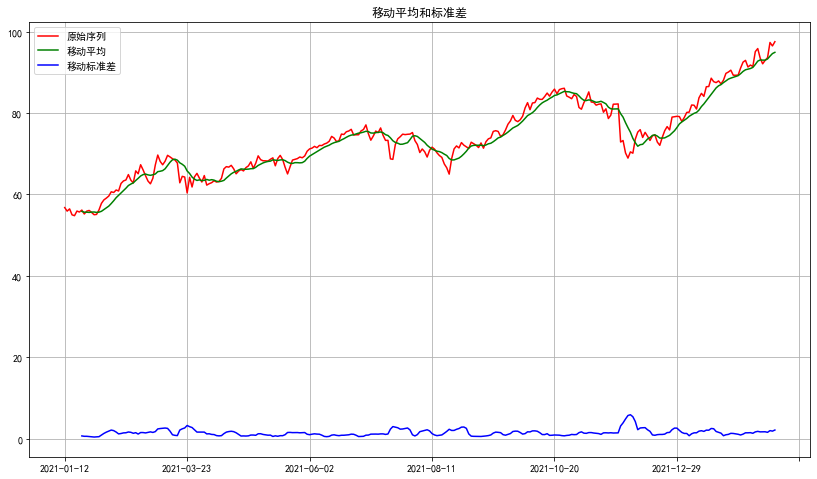

Dickey-Fuller test:
t-stat                   -0.459296
p-val                     0.899718
#lags used                4.000000
no. of obs              286.000000
Critical Value (1%)      -3.453423
Critical Value (5%)      -2.871699
Critical Value (10%)     -2.572183
dtype: float64


In [8]:
test_stationarity(ts)

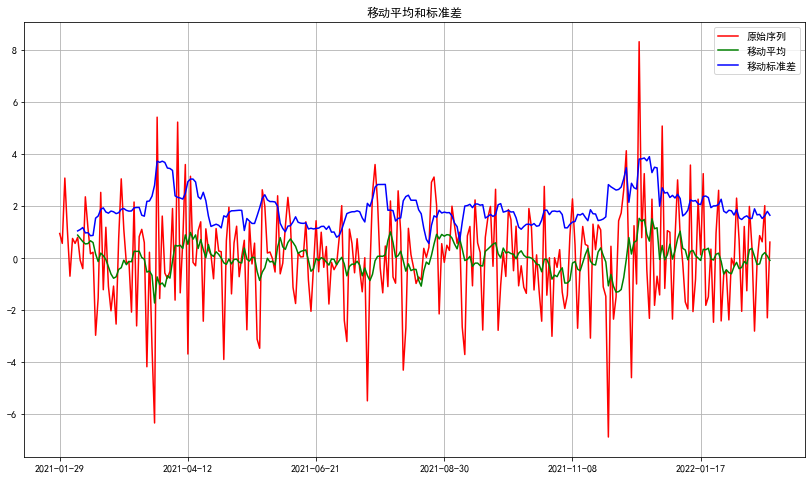

Dickey-Fuller test:
t-stat                 -6.629571e+00
p-val                   5.760421e-09
#lags used              1.100000e+01
no. of obs              2.660000e+02
Critical Value (1%)    -3.455175e+00
Critical Value (5%)    -2.872468e+00
Critical Value (10%)   -2.572593e+00
dtype: float64


In [9]:
ts_first_difference = ts - ts.shift(1) #一阶差分
ts_seasonal_first_difference = ts_first_difference - ts_first_difference.shift(12) #12步差分  
test_stationarity(ts_seasonal_first_difference.dropna(inplace=False))

In [10]:
import statsmodels.api as sm
ts_seasonal_first_difference.dropna(inplace = True)
r,q,p = sm.tsa.acf(ts_seasonal_first_difference.values.squeeze(), qstat=True) 
data = np.c_[range(1,41), r[1:], q, p] 
table = pd.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)"]) 
print(table.set_index('lag'))

            AC           Q      Prob(>Q)
lag                                     
1.0  -0.078736    1.742106  1.868722e-01
2.0  -0.044409    2.298303  3.169056e-01
3.0  -0.065894    3.527338  3.172337e-01
4.0  -0.195710   14.408556  6.099049e-03
5.0   0.054457   15.254126  9.329935e-03
6.0   0.081526   17.156212  8.725966e-03
7.0  -0.007040   17.170446  1.632956e-02
8.0   0.112687   20.831323  7.609260e-03
9.0   0.058705   21.828555  9.438508e-03
10.0 -0.088533   24.105099  7.326260e-03
11.0  0.048350   24.786618  9.795215e-03
12.0 -0.412657   74.617669  4.339147e-11
13.0  0.034608   74.969473  9.644983e-11
14.0  0.116230   78.952718  4.423354e-11
15.0  0.051005   79.722693  7.849350e-11
16.0  0.081561   81.699032  8.209496e-11
17.0  0.031540   81.995717  1.692040e-10
18.0 -0.168960   90.542347  1.153810e-11
19.0 -0.055410   91.465080  1.822712e-11
20.0  0.075236   93.172878  2.055764e-11
21.0 -0.038373   93.618871  3.806189e-11
22.0  0.165966  101.994236  2.885920e-12
23.0  0.095616  

F:\anaconda\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
F:\anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


In [14]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages
from statsmodels.tsa.arima_model import ARIMA 
 
pmax = int(5)    #一般阶数不超过 length /10
qmax = int(5)
bic_matrix = []
for p in range(pmax +1):
    temp= []
    for q in range(qmax+1):
        try:
            temp.append(ARIMA(ts, (p, 1, q)).fit().bic)
        except:
            temp.append(None)
        bic_matrix.append(temp)

bic_matrix = pd.DataFrame(bic_matrix)   #将其转换成Dataframe 数据结构
p,q = bic_matrix.stack().astype('float64').idxmin()   #先使用stack 展平， 然后使用 idxmin 找出最小值的位置
print(u'BIC 最小的p值 和 q 值：%s,%s' %(p,q))  #  BIC 最小的p值 和 q 值：0,1

BIC 最小的p值 和 q 值：0,0


In [12]:
import itertools
def get_ARIMA_params(data, pdq, m=12):
    p = d = q = range(0, 3)
    seasonal_pdq = [(x[0], x[1], x[2], m) for x in list(itertools.product(p, d, q))]
    score_aic = 1000000.0
    warnings.filterwarnings("ignore") # specify to ignore warning messages
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(data,
                                        order=pdq,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
        results = mod.fit()
        print('x{}12 - AIC:{}'.format(param_seasonal, results.aic))
        if results.aic < score_aic:
            score_aic = results.aic
            params = param_seasonal, results.aic
    param_seasonal, results.aic = params
    print('x{}12 - AIC:{}'.format(param_seasonal, results.aic))

In [15]:
pdq = [0, 1, 0]
get_ARIMA_params(ts, pdq)

x(0, 0, 0, 12)12 - AIC:1037.8043286055736
x(0, 0, 1, 12)12 - AIC:1001.5586675167687
x(0, 0, 2, 12)12 - AIC:967.447078467057
x(0, 1, 0, 12)12 - AIC:1153.281639867053
x(0, 1, 1, 12)12 - AIC:980.6681209084054
x(0, 1, 2, 12)12 - AIC:939.2276218722666
x(0, 2, 0, 12)12 - AIC:1385.8980935771435
x(0, 2, 1, 12)12 - AIC:1094.8181455991626
x(0, 2, 2, 12)12 - AIC:955.0464449915587
x(1, 0, 0, 12)12 - AIC:1004.6058464152854
x(1, 0, 1, 12)12 - AIC:1003.3537691297204
x(1, 0, 2, 12)12 - AIC:969.3460441436897
x(1, 1, 0, 12)12 - AIC:1062.7181239522165
x(1, 1, 1, 12)12 - AIC:982.6680314994037
x(1, 1, 2, 12)12 - AIC:938.1549184785276
x(1, 2, 0, 12)12 - AIC:1212.826095953148
x(1, 2, 1, 12)12 - AIC:1060.429173182503
x(1, 2, 2, 12)12 - AIC:957.0472547284423
x(2, 0, 0, 12)12 - AIC:970.0539117119496
x(2, 0, 1, 12)12 - AIC:972.0535964536824
x(2, 0, 2, 12)12 - AIC:969.3917383413926
x(2, 1, 0, 12)12 - AIC:989.9422844280401
x(2, 1, 1, 12)12 - AIC:956.9470039850205
x(2, 1, 2, 12)12 - AIC:947.7801058690899
x(2, 2, 0,

In [17]:
mod = sm.tsa.statespace.SARIMAX(ts, trend='n', order=(0,1,0), seasonal_order=(1,1,2,12))
results = mod.fit()
print(results.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                      收盘   No. Observations:                  291
Model:             SARIMAX(0, 1, 0)x(1, 1, [1, 2], 12)   Log Likelihood                -510.495
Date:                                 Sat, 12 Mar 2022   AIC                           1028.990
Time:                                         22:05:07   BIC                           1043.500
Sample:                                              0   HQIC                          1034.811
                                                 - 291                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.8064      0.226     -3.569      0.000      -1.249      -0

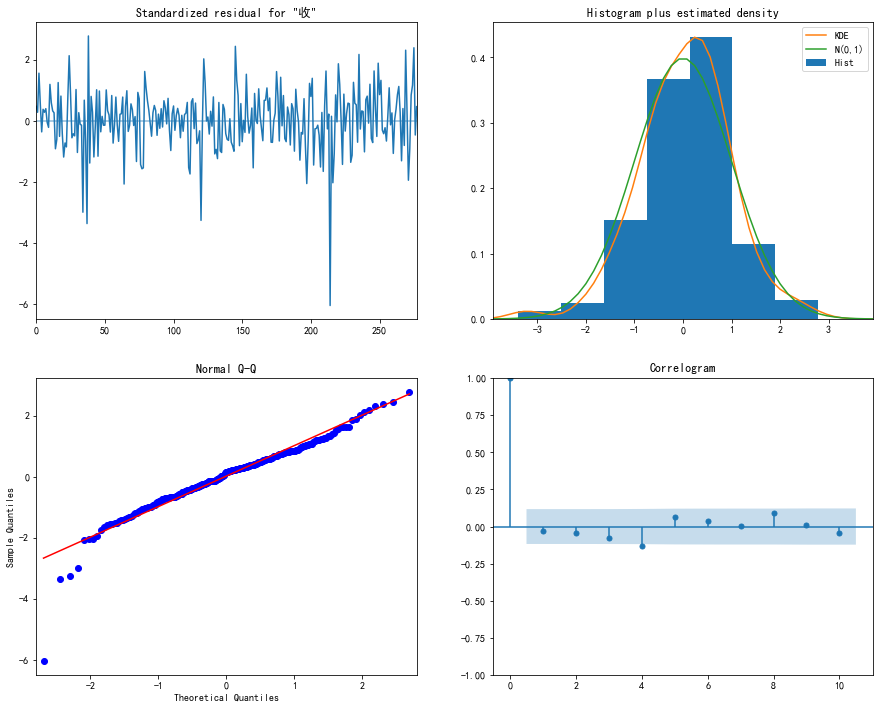

In [18]:
# 模型诊断
results.plot_diagnostics(figsize=(15, 12))
plt.show()

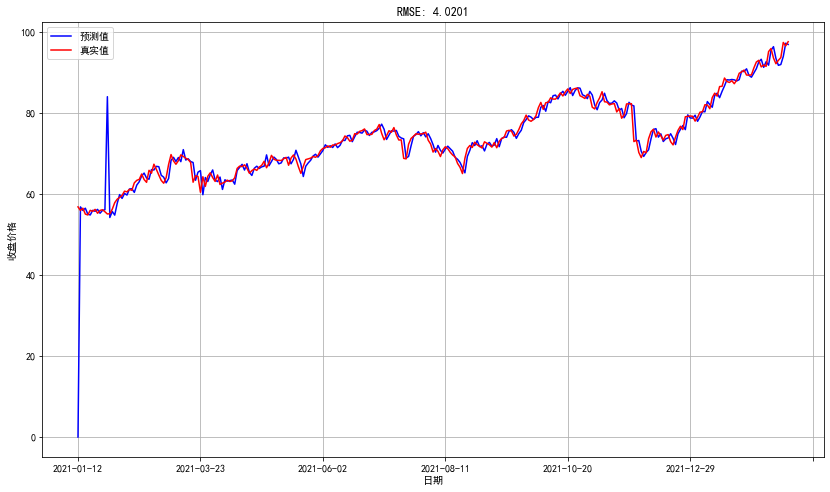

In [19]:
#静态预测
predict_ts = results.predict()
predict_ts.plot(color='blue', label='预测值')
ts.plot(color='red', label='真实值')
plt.legend(loc='best')
plt.title('RMSE: %.4f'% np.sqrt(sum((predict_ts-ts)**2)/ts.size))
#RMSE = np.sqrt(sum((predict_ts-ts)**2)/ts.size
plt.xlabel('日期')
plt.ylabel('收盘价格')
plt.grid()
plt.show()